In [1]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 


C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_082019.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_092019.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_102019.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx',
 'Load Demand_Forecast.xlsx']

In [3]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_012018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_062019.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_072019.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_082019.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_092019.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_102019.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_122018.xlsx']

In [4]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [5]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [6]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head(10)

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-01-01,1,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2018-01-01,2,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645
2,2018-01-01,3,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316
3,2018-01-01,4,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808
4,2018-01-01,5,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510
5,2018-01-01,6,37.843782,751.929837,358.482,592.809796,3527.228368,4675.483986
6,2018-01-01,7,38.717082,746.040356,365.631,609.285487,3600.189330,4750.577768
7,2018-01-01,8,38.556936,729.051897,256.673,619.337395,3667.999929,4692.281762
8,2018-01-01,9,37.718306,753.256276,248.236,614.221973,3803.437022,4842.647604
9,2018-01-01,10,38.377740,745.177096,11.874,621.179152,4196.899298,4992.328134


In [7]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [8]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [9]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [10]:
#subtract one hour to get to 0-23 hour format
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

In [11]:
#set index
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV     Pump      TEL_MV      Network  \
Date       Hour                                                            
2018-01-01 0     34.418093  757.020147    0.000  596.563993  4529.773678   
           1     40.928810  760.024989    0.000  589.266551  4205.128845   
           2     39.286246  750.624526    0.000  585.334471  4116.742544   
           3     38.678094  756.567856    0.120  582.210175  3833.136857   
           4     37.498531  731.949138  130.176  581.251131  3608.455842   

                 ActualTotal  
Date       Hour               
2018-01-01 0     5321.211918  
           1     5006.082645  
           2     4906.653316  
           3     4628.502808  
           4     4508.079510

In [12]:
#set index
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


In [13]:
#merge datasets
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [14]:
#create Timestamp column
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [15]:
#sort by timestamp
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
669,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1338,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
2007,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2676,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [16]:
#create the column of interest
final['LV'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%LVofTotal']=final['LV']/final['ActualTotal']

#find the estimation of XTPrediction
final['LVForecastEstimation']=final['%LVofTotal']*final['ForecastTotalLoad']


In [17]:
#finalize dataset and set frequency
final=final[['Timestamp','LV','Weekday','Holiday','LVForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [18]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-10-31 14:00:00', '2019-10-31 15:00:00',
               '2019-10-31 16:00:00', '2019-10-31 17:00:00',
               '2019-10-31 18:00:00', '2019-10-31 19:00:00',
               '2019-10-31 20:00:00', '2019-10-31 21:00:00',
               '2019-10-31 22:00:00', '2019-10-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=16054, freq=None)

In [19]:
#check for missing values
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

In [20]:
#set Hourly index frequency
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-10-31 14:00:00', '2019-10-31 15:00:00',
               '2019-10-31 16:00:00', '2019-10-31 17:00:00',
               '2019-10-31 18:00:00', '2019-10-31 19:00:00',
               '2019-10-31 20:00:00', '2019-10-31 21:00:00',
               '2019-10-31 22:00:00', '2019-10-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=16056, freq='H')

In [21]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,LV,Weekday,Holiday,LVForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [22]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

LV                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
LVForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [23]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [24]:
#fixed
final.loc['2018-03-25 03:00:00']

LV                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
LVForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

In [25]:
final

,LV,Weekday,Holiday,LVForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143
2019-10-31 20:00:00,3998.556006,4,0,3901.933643
2019-10-31 21:00:00,3681.134314,4,0,3598.459103


# Data Exploration

Text(0.5, 1.0, 'Low Voltage Load Demand VS Holiday')

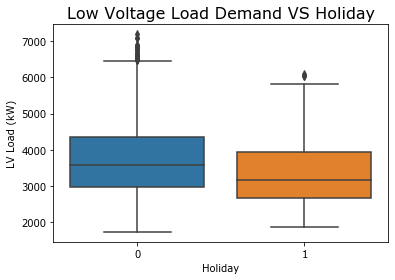

In [26]:
#Here is going to be the EDA part-just some quick insights
import seaborn as sns
sns.boxplot(x=final['Holiday'],y=final['LV']).set(ylabel='LV Load (kW)',xlabel='Holiday')
plt.title('Low Voltage Load Demand VS Holiday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Load Demand VS Weekday')

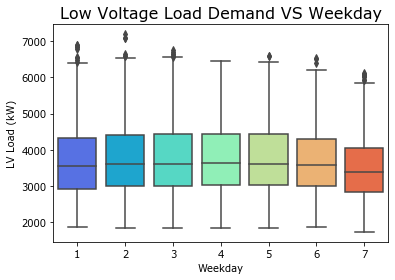

In [27]:
sns.boxplot(x=final['Weekday'],y=final['LV'],palette='rainbow').set(ylabel='LV Load (kW)',xlabel='Weekday')
plt.title('Low Voltage Load Demand VS Weekday',fontsize=16)

Text(0.5, 1.0, 'Low Voltage Load Demand')

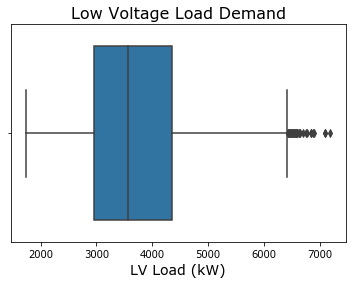

In [28]:
#there are some outliers
sns.boxplot(x=final['LV']).set_xlabel('LV Load (kW)',fontsize=14)
plt.title('Low Voltage Load Demand',fontsize=16)


In [29]:
#check largest Values-seems logical not extreme values
print( final['LV'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-02-13 20:00:00    6129.427284
2019-08-02 17:00:00    6128.394761
2019-02-24 12:00:00    6126.753362
2019-08-01 16:00:00    6124.848840
2018-12-13 20:00:00    6123.033986
Name: LV, Length: 100, dtype: float64


Text(0.5, 1.0, 'Daily Actual LV Load Demand per Hour')

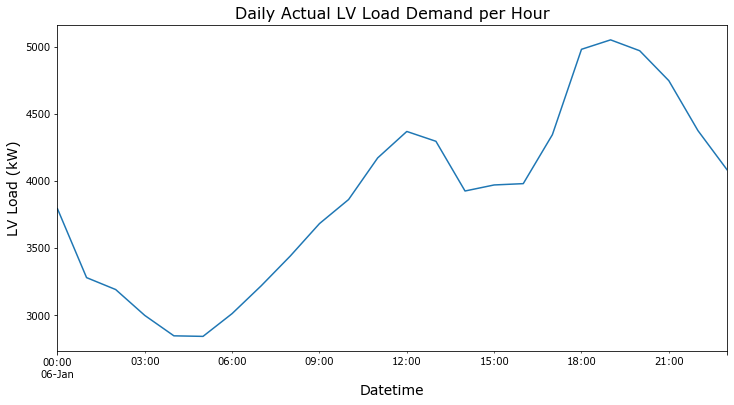

In [30]:
final['LV'].iloc[120:144].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('LV Load (kW)', fontsize=14)
plt.title('Daily Actual LV Load Demand per Hour', fontsize=16)

Text(0.5, 1.0, '2018 Actual LV Load Demand (Historical Data)')

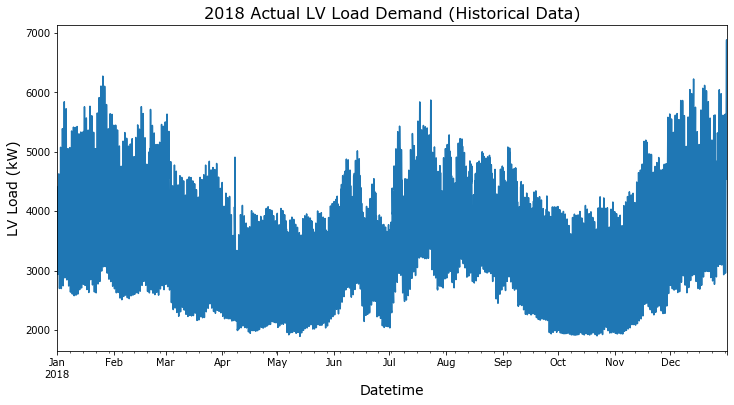

In [31]:
final['LV'].loc['2018-01-01':'2018-12-31'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('LV Load (kW)', fontsize=14)
plt.title('2018 Actual LV Load Demand (Historical Data)', fontsize=16)

Text(0, 0.5, 'Residual')

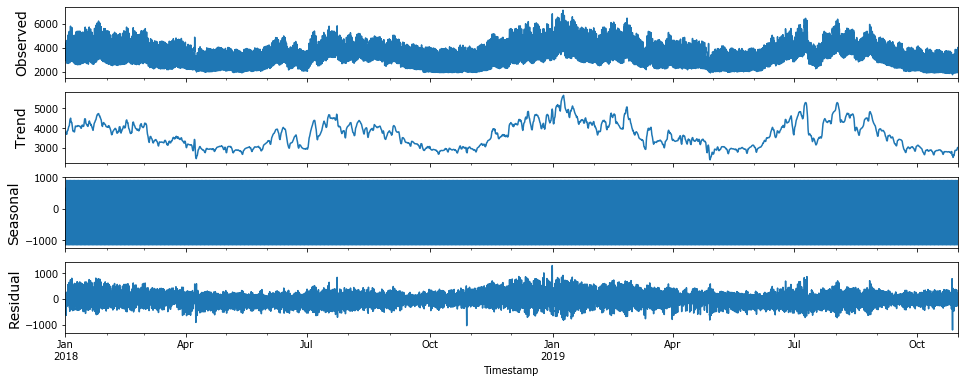

In [32]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['LV'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed',fontsize=14)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend',fontsize=14)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal',fontsize=14)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual',fontsize=14)


In [33]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

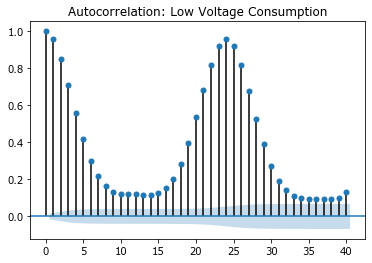

In [35]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Low Voltage Consumption'
lags = 40
plot_acf(final['LV'],title=title,lags=lags);

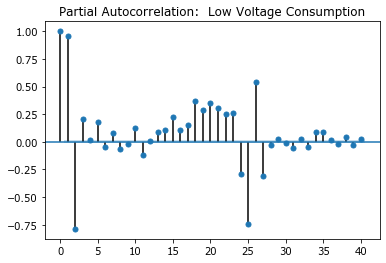

In [36]:
title='Partial Autocorrelation:  Low Voltage Consumption'
lags=40
plot_pacf(final['LV'],title=title,lags=lags);

In [37]:
#KPSS test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [38]:
kpss_test(final['LV'])

Results of KPSS Test:
Test Statistic            0.698710
p-value                   0.013663
Lags Used                59.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [39]:
adf_test(final['LV'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.936734
p-value                     0.001781
# lags used                43.000000
# observations          16012.000000
critical value (1%)        -3.430758
critical value (5%)        -2.861721
critical value (10%)       -2.566866
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [40]:
final2=final

# SARIMAX

In [41]:
# Auto_Arima
model=auto_arima(final2['LV'],
                      m=24,             
                      seasonal=True,   #Seasonality
                      exogenous=final2[['Weekday','Holiday']],
                      trace=True, error_action='ignore', suppress_warnings=True,stepwise=True)

KeyboardInterrupt: 

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                16056
Model:             SARIMAX(1, 1, 1)x(2, 0, 0, 24)   Log Likelihood              -88508.909
Date:                            Wed, 01 Jan 2020   AIC                         177033.818
Time:                                    18:06:53   BIC                         177095.288
Sample:                                         0   HQIC                        177054.145
                                          - 16056                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2356      0.643     -0.366      0.714      -1.497       1.026
x1             2.5371      0.558      4.547      0.000       1.443       3.631
x2            15.6888      3.236      4.848      0.000       9.346      22.031
ar.L1          0.3601      0.006     60.268      0.000       0.348       0.372
ma.L1          0.4019      0.007     61.620      0.000       0.389       0.415
ar.S.L24       0.6684      0.005    147.943      0.000       0.660       0.677
ar.S.L48       0.2891      0.004     64.722      0.000       0.280       0.298
sigma2      3599.6471     16.098    223.604      0.000    3568.095    3631.199
===================================================================================
Ljung-Box (Q):                     1893.18   Jarque-Bera (JB):            135539.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

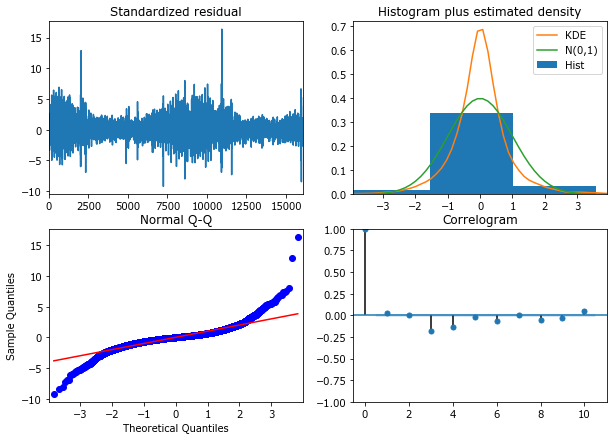

In [44]:
model.plot_diagnostics(figsize=(10,7))
plt.show()

In [136]:
#use the period used for training
df1=final2
df1.shape

(16056, 4)

In [137]:
#train test split
train = df1.loc[:'2019-09-15'].iloc[:-24]
test = df1.loc[:'2019-09-15'].iloc[-24:]

In [138]:
train

,LV,Weekday,Holiday,LVForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
...,...,...,...,...
2019-09-14 19:00:00,3708.124552,6,0,3735.084427
2019-09-14 20:00:00,4076.138779,6,0,4086.716767
2019-09-14 21:00:00,3848.413260,6,0,3862.376071


In [150]:
#run model
model = SARIMAX(train['LV'],
                exog=train[['Holiday','Weekday']],
                order=(1, 1, 1),
                seasonal_order=(2, 0, 0, 24),trend='t',
                enforce_invertibility=False,enforce_stationarity=False)#initialization='approximate_diffuse'
results = model.fit()
results.summary()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 LV   No. Observations:                14928
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 24)   Log Likelihood              -91695.238
Date:                            Thu, 02 Jan 2020   AIC                         183410.476
Time:                                    14:52:23   BIC                         183486.552
Sample:                                01-01-2018   HQIC                        183435.727
                                     - 09-14-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.000     -0.467      0.640      -0.001       0.001
Holiday       23.2846     39.836      0.585      0.559     -54.793     101.362
Weekday       -3.5023      6.694     -0.523      0.601     -16.622       9.617
ar.L1          0.1263      0.077      1.631      0.103      -0.025       0.278
ma.L1          0.4958      0.081      6.136      0.000       0.337       0.654
ar.S.L24       0.7231      0.227      3.180      0.001       0.277       1.169
ar.S.L48       0.2650      0.223      1.187      0.235      -0.172       0.702
ma.S.L24      -0.2304      0.222     -1.036      0.300      -0.666       0.205
ma.S.L48      -0.3618      0.127     -2.852      0.004      -0.610      -0.113
sigma2      3.247e+04    553.649     58.645      0.000    3.14e+04    3.36e+04
===================================================================================
Ljung-Box (Q):                     2127.15   Jarque-Bera (JB):             92634.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('Our Prediction')

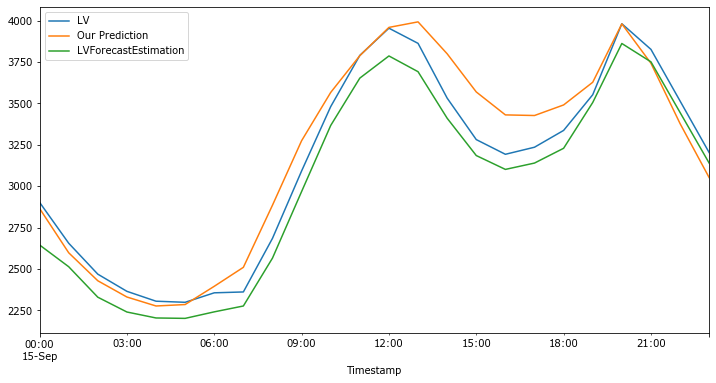

In [152]:
# Plot predictions against known values
ax = test['LV'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['LVForecastEstimation'].loc['2019-09-15'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [153]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(test['LV'], predictions)
TheirError = rmse(final['LVForecastEstimation'].loc['2019-09-15'], test['LV'])

In [154]:
TheirError

123.23233504842186

In [155]:
OurError

137.7661569639559

# Prophet

In [226]:
#import ProphetLibrary
from fbprophet import Prophet

In [227]:
#create weekday Dataframe for possible use by Prophet
temp=test.reset_index()
tholiday= pd.DataFrame({
    'ds': temp['Timestamp'],
    'Holiday': temp['Holiday']
})
tholiday

,ds,Holiday
0,2019-09-15 00:00:00,0
1,2019-09-15 01:00:00,0
2,2019-09-15 02:00:00,0
3,2019-09-15 03:00:00,0
4,2019-09-15 04:00:00,0
5,2019-09-15 05:00:00,0
6,2019-09-15 06:00:00,0
7,2019-09-15 07:00:00,0
8,2019-09-15 08:00:00,0
9,2019-09-15 09:00:00,0


In [228]:
#create weekday Dataframe for possible use by Prophet
temp=train.reset_index()
holiday= pd.DataFrame({
    'ds': temp['Timestamp'],
    'Holiday': temp['Holiday']
})
holiday

,ds,Holiday
0,2018-01-01 00:00:00,1
1,2018-01-01 01:00:00,1
2,2018-01-01 02:00:00,1
3,2018-01-01 03:00:00,1
4,2018-01-01 04:00:00,1
...,...,...
14923,2019-09-14 19:00:00,0
14924,2019-09-14 20:00:00,0
14925,2019-09-14 21:00:00,0
14926,2019-09-14 22:00:00,0


In [229]:
#create weekday Dataframe for possible use by Prophet
temp=train.reset_index()
weekday = pd.DataFrame({
    'ds': temp['Timestamp'],
    'weekday': temp['Weekday']
})
weekday

,ds,weekday
0,2018-01-01 00:00:00,1
1,2018-01-01 01:00:00,1
2,2018-01-01 02:00:00,1
3,2018-01-01 03:00:00,1
4,2018-01-01 04:00:00,1
...,...,...
14923,2019-09-14 19:00:00,6
14924,2019-09-14 20:00:00,6
14925,2019-09-14 21:00:00,6
14926,2019-09-14 22:00:00,6


In [230]:
#create weekday Dataframe for possible use by Prophet
temp=test.reset_index()
tweekday = pd.DataFrame({
    'ds': temp['Timestamp'],
    'weekday': temp['Weekday']
})
tweekday

,ds,weekday
0,2019-09-15 00:00:00,7
1,2019-09-15 01:00:00,7
2,2019-09-15 02:00:00,7
3,2019-09-15 03:00:00,7
4,2019-09-15 04:00:00,7
5,2019-09-15 05:00:00,7
6,2019-09-15 06:00:00,7
7,2019-09-15 07:00:00,7
8,2019-09-15 08:00:00,7
9,2019-09-15 09:00:00,7


In [231]:
train1=pd.merge(weekday, holiday, left_on='ds', right_on='ds', how='left')

In [232]:
test1=pd.merge(tweekday, tholiday, left_on='ds', right_on='ds', how='left')

In [233]:
fs=pd.merge(train['LV'].reset_index().rename(columns={'Timestamp':'ds', 'LV':'y'}), tenp1, left_on='ds', right_on='ds', how='left')

In [234]:
fs.rename(columns={'Holiday':'holiday'}, inplace=True)
test1.rename(columns={'Holiday':'holiday'}, inplace=True)

In [235]:
fs2=fs.append(test1)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [236]:
fs2

,ds,holiday,weekday,y
0,2018-01-01 00:00:00,1,1,3933.209685
1,2018-01-01 01:00:00,1,1,3615.862294
2,2018-01-01 02:00:00,1,1,3531.408073
3,2018-01-01 03:00:00,1,1,3250.926682
4,2018-01-01 04:00:00,1,1,3027.204711
...,...,...,...,...
19,2019-09-15 19:00:00,0,7,NaN
20,2019-09-15 20:00:00,0,7,NaN
21,2019-09-15 21:00:00,0,7,NaN
22,2019-09-15 22:00:00,0,7,NaN


In [237]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,growth='linear'
                    ,seasonality_mode='multiplicative',changepoint_prior_scale=50,seasonality_prior_scale=50,holidays_prior_scale=30
                     )#.add_seasonality(name='daily',period=24,fourier_order=20).add_seasonality(name='weekly',period=168,fourier_order=20)
prophet_model.add_regressor('holiday')
prophet_model.add_regressor('weekday')
prophet_model.fit(fs)

In [238]:
#predict
prophet_forecast = prophet_model.predict(fs2[['ds','holiday','weekday']])

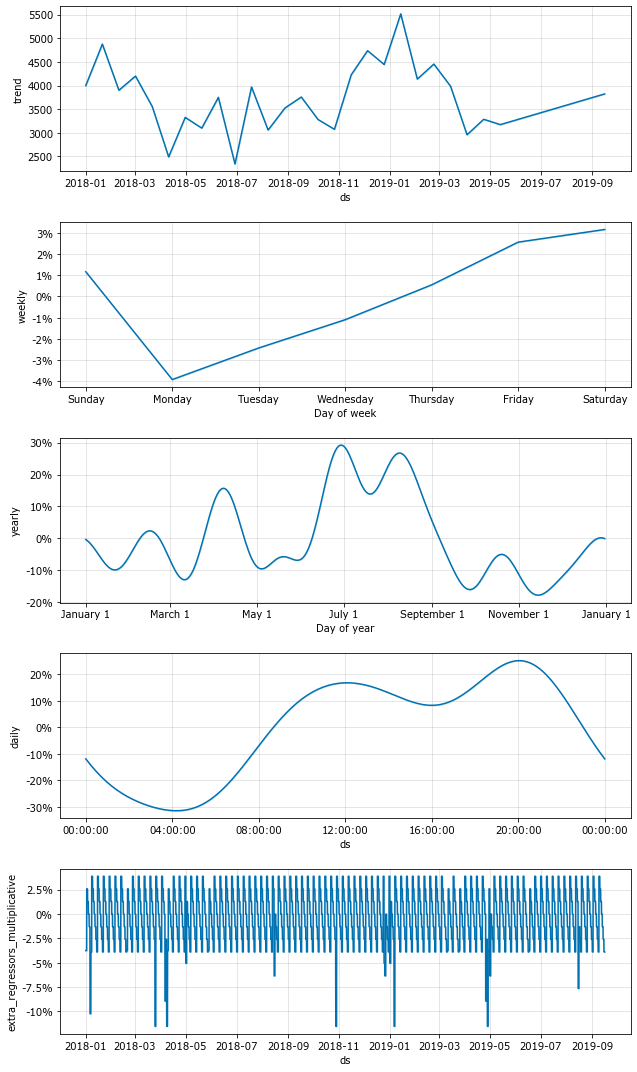

In [239]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

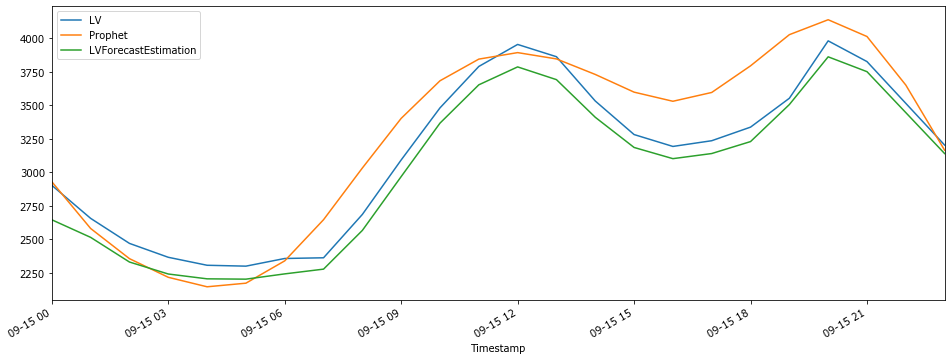

In [240]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['LV'], label='LV')
axes.plot(test.index, prophet_forecast['yhat'].tail(24), label='Prophet', axes=axes)
final['LVForecastEstimation'].loc['2019-09-15'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [163]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['LV'], prophet_forecast['yhat'].tail(24))

In [164]:
#worse
prophet_error

235.2087046210609

# LSTM 

In [114]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [115]:
#final_lstm_multi = final[['Weekday','LV','Holiday']]
final_lstm_multi = final2[['Weekday','LV','Holiday']]
final_lstm_multi = pd.DataFrame(final_lstm_multi)
final_lstm_multi= final_lstm_multi.loc['2018-01-01':'2019-10-31']
final_lstm_multi.head()

,Weekday,LV,Holiday
Timestamp,,,
2018-01-01 00:00:00,1,3933.209685,1
2018-01-01 01:00:00,1,3615.862294,1
2018-01-01 02:00:00,1,3531.408073,1
2018-01-01 03:00:00,1,3250.926682,1
2018-01-01 04:00:00,1,3027.204711,1


In [116]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler


ct = ColumnTransformer([
        ("weekday", OneHotEncoder(categories='auto'), [0]),
        ("LV", MinMaxScaler(feature_range=(0,1)), [1]),
        ("holiday", "passthrough", [2])],
        sparse_threshold=0)

In [117]:
final_lstm_multi['LV']=sc.fit_transform(final_lstm_multi[['LV']])

In [118]:
dataset = ct.fit_transform(final_lstm_multi.values)
dataset[0:100:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.40280533, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.4197427 , 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.52861615, 1.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.21481504, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.45699946, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.22887572, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.527287  , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.51736151, 0.        ],


In [119]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [120]:
TRAIN_SPLIT = dataset.shape[0] * 2 // 3
TRAIN_SPLIT

10704

In [121]:
STEP = 1 # We are going to use all samples

In [122]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, 
                      step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [123]:
past_history = 15 * 24 # 15 days in the past
future_target = 24 # one day in the future

In [124]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [125]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target load to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (360, 9)
Target load to predict : (24,)


In [126]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train_multi.shape[0]
BUFFER_SIZE

10344

In [127]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [128]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(16, 10))
    num_in = [ x for x in range(-int(history.shape[0]), 0, 1)]
    num_out = int(true_future.shape[0])

    plt.plot(num_in, np.array(history[:, -2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 
             color='green',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 
                 color='brown',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

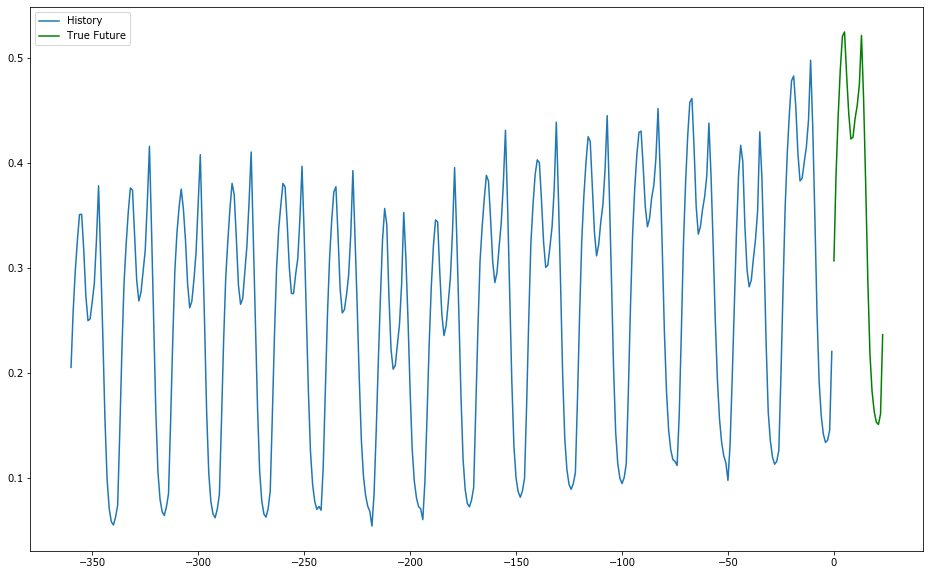

In [129]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [130]:
multivariate_model = tf.keras.models.Sequential()
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True, 
                                            input_shape=x_train_multi.shape[-2:]))
multivariate_model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
multivariate_model.add(tf.keras.layers.LSTM(units=50))
multivariate_model.add(tf.keras.layers.Dense(units=24))
multivariate_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 360, 100)          44000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 360, 100)          80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1224      
Total params: 155,824
Trainable params: 155,824
Non-trainable params: 0
_________________________________________________________________


In [131]:
multivariate_model.compile(optimizer='adam', loss='mean_squared_error')

In [132]:
for x, y in val_data_multi.take(1):
    print (multivariate_model.predict(x).shape)

(256, 24)


In [133]:
multivariate_history = multivariate_model.fit(train_data_multi, 
                                              epochs=15,
                                              steps_per_epoch=x_train_multi.shape[0] / BATCH_SIZE,
                                              validation_data=val_data_multi,
                                              validation_steps=50)

Train for 40.40625 steps, validate for 50 steps
Epoch 1/20
41/40 [==============================] - 338s 8s/step - loss: 0.0470 - val_loss: 0.0165
Epoch 2/20
41/40 [==============================] - 335s 8s/step - loss: 0.0189 - val_loss: 0.0135
Epoch 3/20
41/40 [==============================] - 356s 9s/step - loss: 0.0111 - val_loss: 0.0061
Epoch 4/20
41/40 [==============================] - 382s 9s/step - loss: 0.0066 - val_loss: 0.0052
Epoch 5/20
41/40 [==============================] - 402s 10s/step - loss: 0.0056 - val_loss: 0.0046
Epoch 6/20
41/40 [==============================] - 430s 10s/step - loss: 0.0043 - val_loss: 0.0036
Epoch 7/20
41/40 [==============================] - 455s 11s/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/20
41/40 [==============================] - 477s 12s/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
41/40 [==============================] - 506s 12s/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/20
41/40 [==============================] - 518

In [134]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

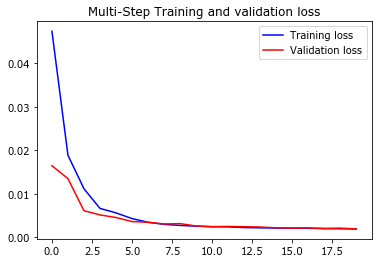

In [135]:
plot_train_history(multivariate_history, 'Multi-Step Training and validation loss')

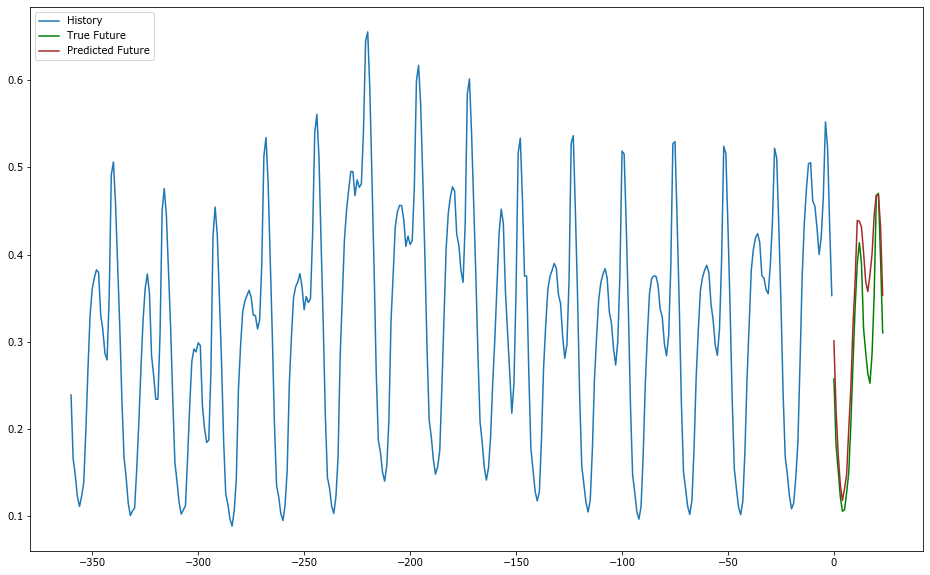

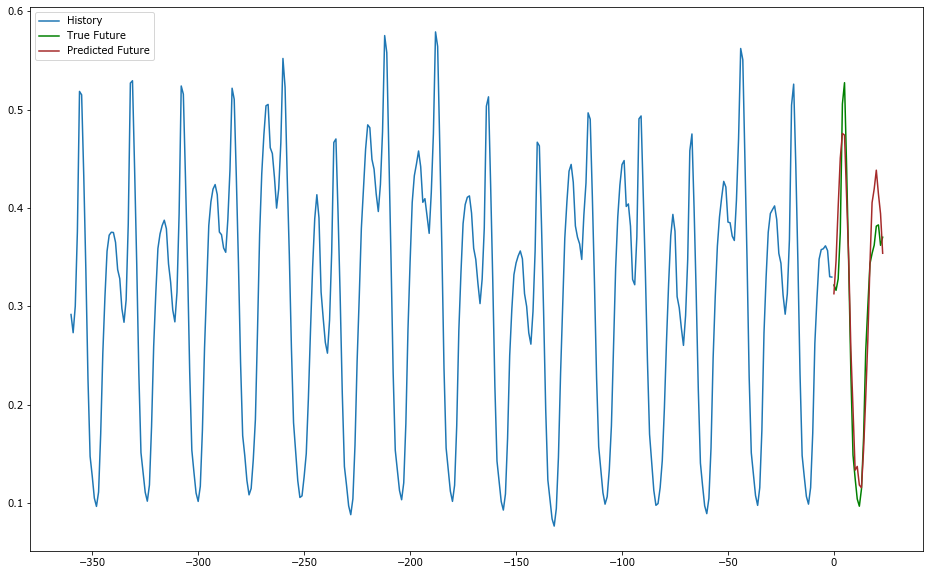

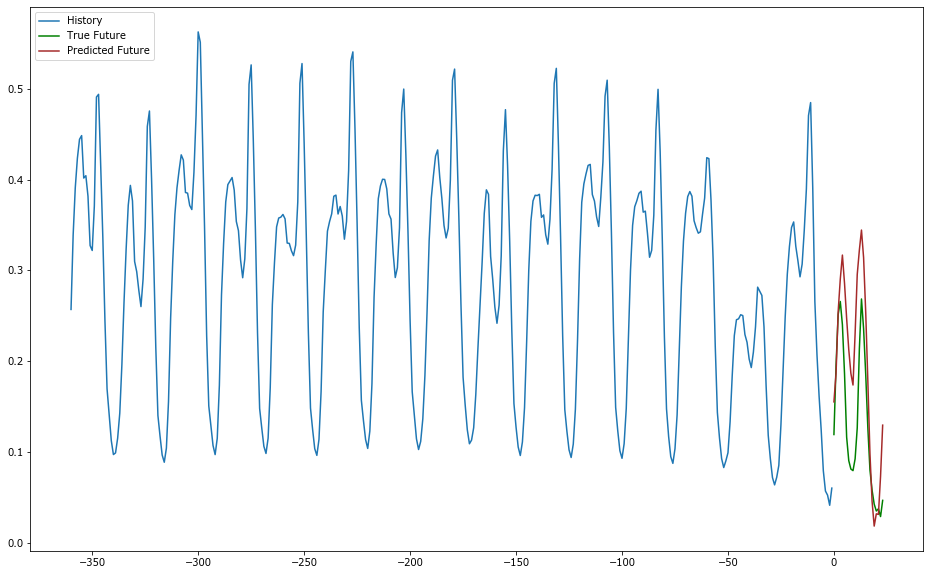

In [136]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multivariate_model.predict(x)[0])

In [138]:
from statsmodels.tools.eval_measures import mse,rmse
def evaluate_LSTM(z,y):
    scores=[]
    for i in range(0,z.shape[0]):
    
        trainPredict_dataset_like=np.zeros(shape=(len(z[i]),3))
        trainPredict_dataset_like[:,1]=z[i]
        Predict=sc.inverse_transform(trainPredict_dataset_like)[:,1]
    
        actual_dataset_like=np.zeros(shape=(len(np.asarray(y[i])),3))
        actual_dataset_like[:,1]=np.asarray(y[i])
        actual=sc.inverse_transform(actual_dataset_like)[:,1]
        scores.append(rmse(Predict,actual))
    
    return scores, sum(scores) / len(scores)

In [139]:
evaluate_LSTM(multivariate_model.predict(x),y)

([441.9293852754578,
  422.7895782897286,
  422.7945594035934,
  434.9465366860947,
  439.56790909569213,
  430.7665290926094,
  404.24183891617247,
  361.057757951763,
  313.4237359442112,
  263.5837098681428,
  217.18517656838176,
  190.01957263323362,
  178.794899867558,
  159.69134930237493,
  127.43199052181892,
  133.91464650275188,
  140.23036530711207,
  148.82005986510322,
  147.3184741842277,
  137.2360129388055,
  154.63337871479544,
  157.12551910074046,
  139.8102012314005,
  124.25195766157431,
  107.96309687499306,
  106.78363092391186,
  100.0505345994173,
  93.34450931058774,
  103.58928379675629,
  137.28761872346558,
  149.7540932580638,
  138.92764652853577,
  151.20289219085575,
  179.32698659270403,
  206.83033005716624,
  231.92426559268264,
  248.17542344162314,
  256.33557670727157,
  262.05240142395206,
  287.3352294167171,
  303.26245512304195,
  304.0923215253105,
  287.3442444398355,
  267.42436747792476,
  260.4319226344285,
  252.216005031765,
  244.20650

# More Feature Engineering

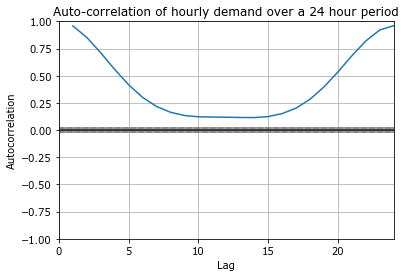

In [143]:
#The autocorrelation plot below shows the extent to which the demand variable correlates with itself at different intervals (lags). 
#This plot shows that demand is highly autocorrelated over the closest 6 hour period.
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(final2['LV'])
plt.xlim(0,24)
plt.title('Auto-correlation of hourly demand over a 24 hour period')
plt.show()

In [144]:
def generate_lagged_features(df, max_lag):
    for t in range(1, max_lag+1):
        df['LV_lag'+str(t)] = df['LV'].shift(t, freq='1H')

In [145]:
final3=final2.copy()

In [146]:
generate_lagged_features(final2, 6)

In [147]:
final2['Timestamp'] = final2.index

In [148]:
final2['Day'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%d'))
final2['Month'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%m'))
final2['Year'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%Y'))
final2['Hour'] = pd.to_numeric(final2['Timestamp'].dt.strftime('%H'))

In [149]:
final2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16056 entries, 2018-01-01 00:00:00 to 2019-10-31 23:00:00
Freq: H
Data columns (total 15 columns):
LV                      16056 non-null float64
Weekday                 16056 non-null int64
Holiday                 16056 non-null int64
LVForecastEstimation    16056 non-null float64
LV_lag1                 16055 non-null float64
LV_lag2                 16054 non-null float64
LV_lag3                 16053 non-null float64
LV_lag4                 16052 non-null float64
LV_lag5                 16051 non-null float64
LV_lag6                 16050 non-null float64
Timestamp               16056 non-null datetime64[ns]
Day                     16056 non-null int64
Month                   16056 non-null int64
Year                    16056 non-null int64
Hour                    16056 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(6)
memory usage: 2.6 MB


In [150]:
final2.dropna(how='any', inplace=True)


In [151]:
final2

,LV,Weekday,Holiday,LVForecastEstimation,LV_lag1,LV_lag2,LV_lag3,LV_lag4,LV_lag5,LV_lag6,Timestamp,Day,Month,Year,Hour
Timestamp,,,,,,,,,,,,,,,
2018-01-01 06:00:00,2990.903843,1,1,2645.526199,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685,2018-01-01 06:00:00,1,1,2018,6
2018-01-01 07:00:00,3048.662534,1,1,2778.846267,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,2018-01-01 07:00:00,1,1,2018,7
2018-01-01 08:00:00,3189.215049,1,1,3011.633638,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,2018-01-01 08:00:00,1,1,2018,8
2018-01-01 09:00:00,3575.720146,1,1,3690.084004,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,2018-01-01 09:00:00,1,1,2018,9
2018-01-01 10:00:00,4025.499981,1,1,4290.197566,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,2018-01-01 10:00:00,1,1,2018,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4050.675054,4,0,3961.302143,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619,3608.437275,2019-10-31 19:00:00,31,10,2019,19
2019-10-31 20:00:00,3998.556006,4,0,3901.933643,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619,2019-10-31 20:00:00,31,10,2019,20
2019-10-31 21:00:00,3681.134314,4,0,3598.459103,3998.556006,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283,2019-10-31 21:00:00,31,10,2019,21


# ML

In [152]:
final2=final2[['Weekday','Holiday','Year','Month','Hour','LV','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]

In [153]:
final2

,Weekday,Holiday,Year,Month,Hour,LV,LV_lag1,LV_lag2,LV_lag3,LV_lag4,LV_lag5,LV_lag6
Timestamp,,,,,,,,,,,,
2018-01-01 06:00:00,1,1,2018,1,6,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294,3933.209685
2018-01-01 07:00:00,1,1,2018,1,7,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073,3615.862294
2018-01-01 08:00:00,1,1,2018,1,8,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682,3531.408073
2018-01-01 09:00:00,1,1,2018,1,9,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711,3250.926682
2018-01-01 10:00:00,1,1,2018,1,10,4025.499981,3575.720146,3189.215049,3048.662534,2990.903843,2934.418572,3027.204711
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,4,0,2019,10,19,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619,3608.437275
2019-10-31 20:00:00,4,0,2019,10,20,3998.556006,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283,3488.646619
2019-10-31 21:00:00,4,0,2019,10,21,3681.134314,3998.556006,4050.675054,4008.164369,3551.311406,3207.483538,3262.911283


In [154]:
X_train=final2.loc[:'2019-08-31'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_train=final2.loc[:'2019-08-31']['LV']

In [155]:
X_test=final2.loc['2019-09-15':'2019-09-15'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_test=final2.loc['2019-09-15':'2019-09-15']['LV'].to_frame()

In [156]:
y_their=final.loc['2019-09-15':'2019-09-15']['LVForecastEstimation']

Το εκανα το scaling αλλα δεν ειχε αποτελεσμα οποτε λεω να το βγάλω

In [72]:
#from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range=(0,1))

In [73]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import OneHotEncoder

#from sklearn.preprocessing import MinMaxScaler
#ct_x = ColumnTransformer([

 #       ("Day", OneHotEncoder(categories='auto'), [0]),
 #       ("Year", OneHotEncoder(categories='auto'), [1]),
 #       ("Month", OneHotEncoder(categories='auto'), [2]),
 #       ("Hour", OneHotEncoder(categories='auto'), [3]),
 #       ("weekday", OneHotEncoder(categories='auto'), [4]),
 #       ("holiday", OneHotEncoder(categories='auto'), [5]),
 #       ("'XT_lag1'", MinMaxScaler(feature_range=(0,1)), [6]),
 #       ("'XT_lag2'", MinMaxScaler(feature_range=(0,1)), [7]),
 #       ("'XT_lag3'", MinMaxScaler(feature_range=(0,1)), [8]),
 #       ("'XT_lag4'", MinMaxScaler(feature_range=(0,1)), [9]),
 #       ("'XT_lag5'", MinMaxScaler(feature_range=(0,1)), [10]),
 #      ("'XT_lag6'", MinMaxScaler(feature_range=(0,1)), [11])])

In [74]:
#y = sc.fit_transform(y_train.values.reshape(-1, 1))

In [75]:
#X = ct_x.fit_transform(X_train.values)
#Xt = ct_x.transform(X_test.values)

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as boost
from sklearn.model_selection import cross_val_score

In [158]:
#create function for mean square error
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [159]:
#Lasso
model_lassoCV=LassoCV()
model_lassoCV.fit(X_train,y_train)
rmse_lassoCV=rmse_cv(model_lassoCV).mean()
rmse_lassoCV

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW

167.55137855560824

In [160]:
#RidgeCV
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y_train)
rmse_RidgeCV = rmse_cv(model_RidgeCV).mean()
rmse_RidgeCV

167.38522531050995

In [161]:
#KernerlRidge
model_KernelRidge=KernelRidge()
model_KernelRidge.fit(X_train,y_train)
rmse_KernelRidge=rmse_cv(model_KernelRidge).mean()
rmse_KernelRidge


166.40999562760987

In [162]:
#ElasticNet
model_ElasticNet=ElasticNet()
model_ElasticNet.fit(X_train,y_train)
model_ElasticNet=rmse_cv(model_ElasticNet).mean()
model_ElasticNet

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187318261.48333323, tolerance: 1358618.0384616842
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159529771.70275956, tolerance: 1219277.4193646775
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167862525.14821437, tolerance: 1246615.856600599
  positive)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

166.43874636386718

In [163]:
#RandomForestRegressor
RFMregressor = RandomForestRegressor(n_estimators = 500, random_state = 0, n_jobs = -1) 
RFMregressor.fit(X_train,y_train)
RFMregressor=rmse_cv(RFMregressor).mean()
RFMregressor


99.53200401861375

In [164]:
#XGBRegressor
tuned_model_boost = boost.XGBRegressor(learning_rate=.05, max_depth=3, n_estimators=500) 
tuned_model_boost.fit(X_train,y_train)
tuned_model_boost=rmse_cv(tuned_model_boost).mean()
tuned_model_boost

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


116.86716663904477

In [165]:
#GradientBoosting
GBregressor = GradientBoostingRegressor()
GBregressor.fit(X_train,y_train)
GBregressor=rmse_cv(GBregressor).mean()
GBregressor

138.50855819621486

So we choose the RFRegressor

# GridSearch RF

In [166]:
from sklearn.model_selection import GridSearchCV

In [167]:
rfc=RandomForestRegressor(random_state = 0,n_estimators=700,
                          min_samples_leaf=1,min_samples_split=2,max_features='auto',max_depth=20)

param_grid = { 
    'n_estimators': [200, 300,400,500,600,700,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15, 100],
    'max_depth' : [5,10,15,20,25,30],
    'min_samples_leaf' : [1, 2, 5, 10]
}


In [168]:
#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
#CV_rfc.fit(X_train, y_train)
#print(CV_rfc.best_params_)
#{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

Forecast the same day as the models before in order to be able to compare.

In [169]:
#fit the model
f=rfc.fit(X_train,y_train)

In [170]:
#make predictions
y_1= f.predict(X_test)

In [171]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(y_1, y_test['LV'])

In [172]:
#Our Error for 24 hour predictions
OurError

65.1199786233645

In [173]:
#TheirError for 24 hour predictions
TheirError= rmse(y_their, y_test['LV'])

In [174]:
TheirError

123.23233504842186

In [175]:
#prediction data maniulation
t=pd.DataFrame(y_test.index)
t1=pd.DataFrame({'Pred':y_1})
result = pd.concat([t, t1], axis=1, sort=False)
result.set_index('Timestamp',inplace=True)
t2=pd.DataFrame(final.loc['2019-09-15':'2019-09-15']['LVForecastEstimation'])
result2=pd.concat([result,t2],axis=1,sort=False)
result3=pd.concat([result2,y_test],axis=1,sort=False)


In [176]:
result3.columns = ['Prediction', 'Pred(ADMHE)','Actual']

In [177]:
result3

,Prediction,Pred(ADMHE),Actual
Timestamp,,,
2019-09-15 00:00:00,2858.344187,2645.300607,2902.763294
2019-09-15 01:00:00,2594.609270,2513.984774,2655.955430
2019-09-15 02:00:00,2523.246418,2329.880614,2469.018933
2019-09-15 03:00:00,2360.118355,2240.425081,2365.265871
2019-09-15 04:00:00,2295.466957,2204.395112,2305.693300
2019-09-15 05:00:00,2311.975608,2201.969460,2299.071236
2019-09-15 06:00:00,2359.732903,2241.353874,2356.332090
2019-09-15 07:00:00,2546.876483,2276.785073,2361.557496
2019-09-15 08:00:00,2577.201846,2565.957350,2685.277618


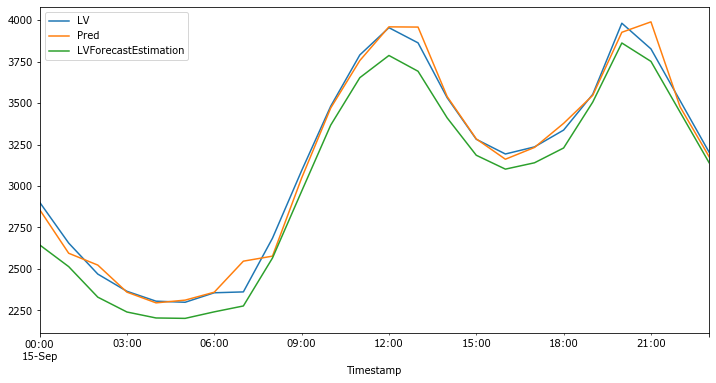

In [178]:
# Plot all of them in different weekly periods
ax = y_test['LV'].loc['2019-09-15':'2019-09-15'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-15':'2019-09-15'].plot(legend=True)
y_their.loc['2019-09-15':'2019-09-15'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

# Whole Month Forecast Experiment

In [179]:
X_train=final2.loc[:'2019-08-31'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_train=final2.loc[:'2019-08-31']['LV']

In [180]:
X_test=final2.loc['2019-09-01':'2019-09-30'][['Year','Month','Hour','Weekday','Holiday','LV_lag1','LV_lag2','LV_lag3','LV_lag4','LV_lag5','LV_lag6']]
y_test=final2.loc['2019-09-01':'2019-09-30']['LV'].to_frame()

In [181]:
y_their=final.loc['2019-09-01':'2019-09-30']['LVForecastEstimation']

In [182]:
rfc=RandomForestRegressor(random_state = 0,n_estimators=700,
                          min_samples_leaf=1,min_samples_split=2,max_features='auto',max_depth=20)

In [183]:
#fit the model
f=rfc.fit(X_train,y_train)

In [184]:
#make predictions
y_1= f.predict(X_test)

In [185]:
from statsmodels.tools.eval_measures import mse,rmse
#calculate rmse
OurError= rmse(y_1, y_test['LV'])

In [186]:
#Our Error for whole september
OurError

74.27597495145537

In [187]:
TheirError= rmse(y_their, y_test['LV'])

In [188]:
#Their Error for whole september
TheirError

88.1461224329604

In [189]:
#prediction data maniulation
t=pd.DataFrame(y_test.index)
t1=pd.DataFrame({'Pred':y_1})
result = pd.concat([t, t1], axis=1, sort=False)
result.set_index('Timestamp',inplace=True)
t2=pd.DataFrame(final.loc['2019-09-01':'2019-09-30']['LVForecastEstimation'])
result2=pd.concat([result,t2],axis=1,sort=False)
result3=pd.concat([result2,y_test],axis=1,sort=False)


In [190]:
result3.columns = ['Prediction', 'Pred(ADMHE)','Actual']

In [191]:
result3

,Prediction,Pred(ADMHE),Actual
Timestamp,,,
2019-09-01 00:00:00,3515.700451,3499.514338,3549.123970
2019-09-01 01:00:00,3227.319647,3235.462588,3283.696417
2019-09-01 02:00:00,3082.756459,3033.586654,3073.410633
2019-09-01 03:00:00,2946.067803,2900.084989,2928.807426
2019-09-01 04:00:00,2833.724689,2804.914082,2834.027904
...,...,...,...
2019-09-30 19:00:00,3667.310119,3858.535581,3826.308438
2019-09-30 20:00:00,4235.171489,4122.569953,4075.101694
2019-09-30 21:00:00,3855.378752,3813.867927,3763.093504


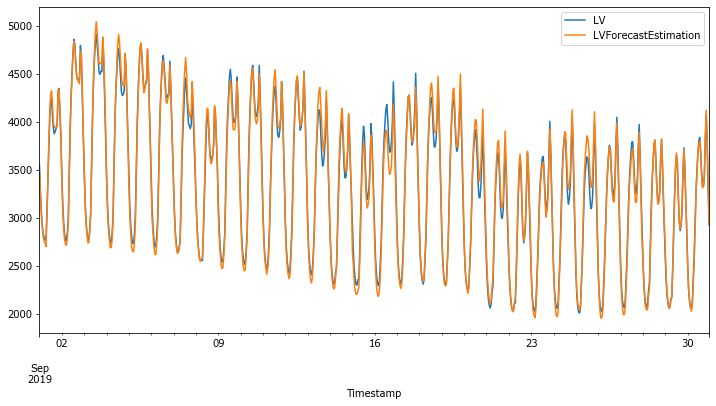

In [192]:
# Plot ADMHE predictions vs actuals
ax = y_test['LV'].plot(legend=True,figsize=(12,6))
y_their.plot(legend=True)
ax.autoscale(axis='x',tight=True)

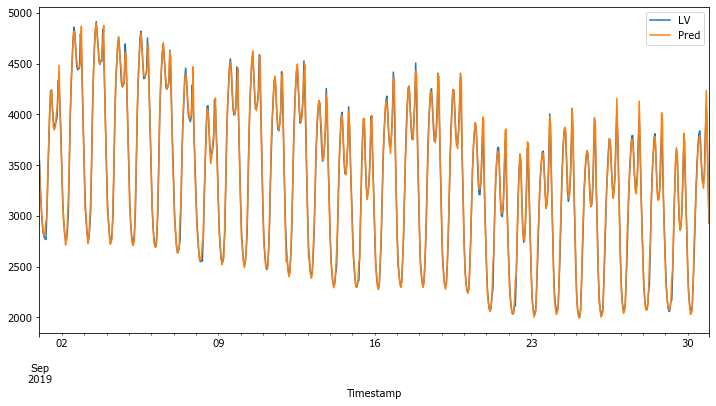

In [193]:
# Plot predictions vs actuals
ax = y_test['LV'].plot(legend=True,figsize=(12,6))
result['Pred'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

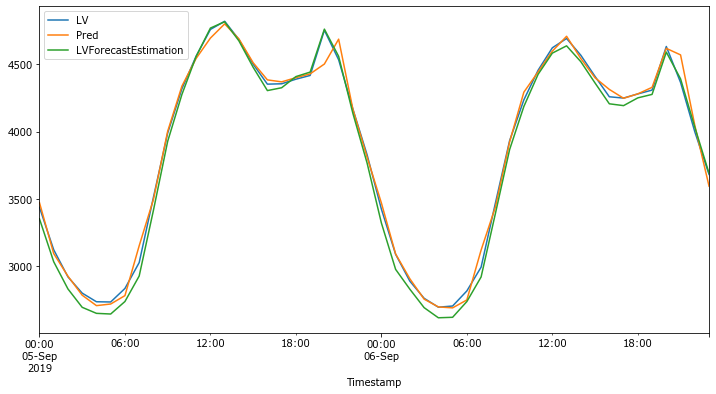

In [194]:
# Plot all of them in different daily periods10
ax = y_test['LV'].loc['2019-09-05':'2019-09-06'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-05':'2019-09-06'].plot(legend=True)
y_their.loc['2019-09-05':'2019-09-06'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

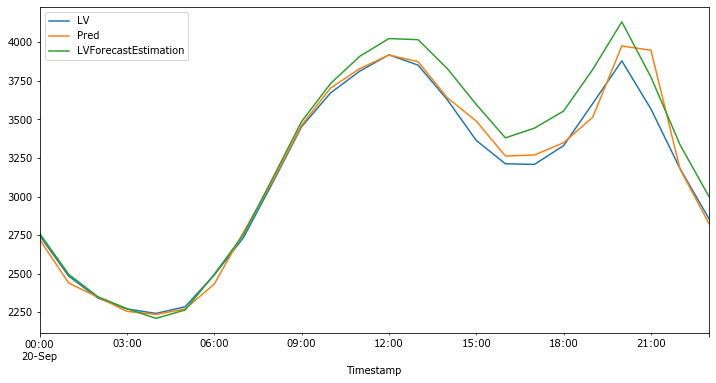

In [195]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-20':'2019-09-20'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-20':'2019-09-20'].plot(legend=True)
y_their.loc['2019-09-20':'2019-09-20'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

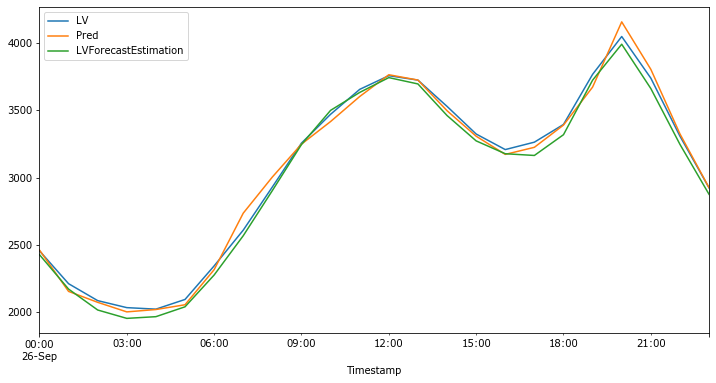

In [196]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-26':'2019-09-26'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-26':'2019-09-26'].plot(legend=True)
y_their.loc['2019-09-26':'2019-09-26'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

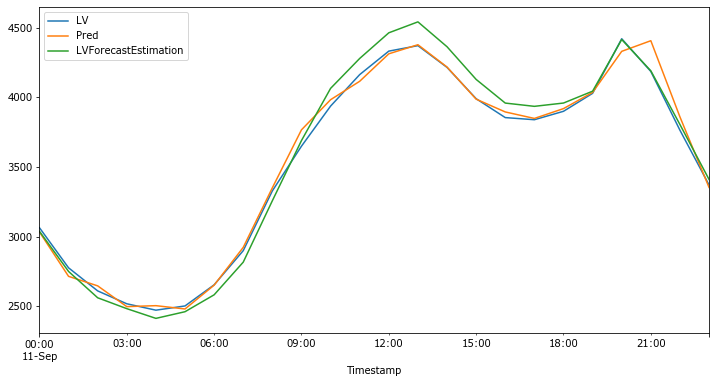

In [197]:
# Plot all of them in different daily periods
ax = y_test['LV'].loc['2019-09-11':'2019-09-11'].plot(legend=True,figsize=(12,6))
result['Pred'].loc['2019-09-11':'2019-09-11'].plot(legend=True)
y_their.loc['2019-09-11':'2019-09-11'].plot(legend=True)
ax.autoscale(axis='x',tight=True)